<a href="https://colab.research.google.com/github/DrAlexSanz/Data-Week-1-DNN/blob/master/Create_a_NN_with_classes_to_clasify_non_linear_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from pandas import read_hdf
import sklearn
import sklearn.datasets
import sklearn.linear_model
# from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

print("Everything ok so far. This is encouraging.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Everything ok so far. This is encouraging.


Now create dataset.

In [0]:
np.random.seed(1)
m = 400 # number of examples
N = int(m/2) # number of points per class
D = 2 # dimensionality
X = np.zeros((m,D)) # data matrix where each row is a single example
Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
a = 4 # maximum ray of the flower

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j
        
# X = X.T
# Y = Y.T

Now plot this to check that I created the dataset properly.

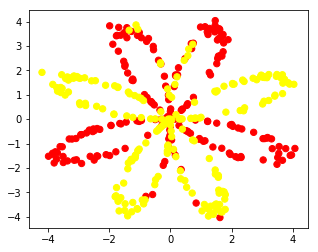

In [70]:
plt.scatter(X[:,0], X[:,1], c = Y.ravel(), s = 40, cmap = plt.cm.autumn) #ravel!!!

It works, don't forget the .ravel() for c in the scatter. Also, the colors are a bit ugly, but why not?

Now I'll do a simple logistic regression to try to classify. It's not linearly separable, but let's see.

In [71]:
logreg = sklearn.linear_model.LogisticRegressionCV()
logreg.fit(X, Y.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

To plot the boundary I need to rescue my old meshgrid code.

Accuracy of logistic regression: 47 % (percentage of correctly predicted points)


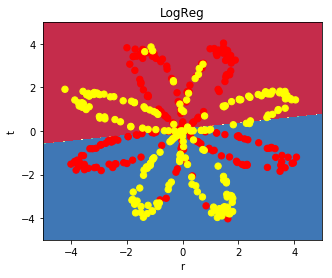

In [72]:
# Set min and max values and give it some padding

x_min, x_max = -5, 5
y_min, y_max = -5, 5

h = 0.01
# Generate a grid of points with distance h between them
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predict the function value for the whole grid
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot the contour and training examples
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('t')
plt.xlabel('r')
plt.scatter(X[:, 0], X[:, 1], c = Y.ravel(), s = 40, cmap = plt.cm.autumn)



# plot_decision_boundary = (lambda x: logreg.predict(x), X, Y.ravel())
plt.title("LogReg")

logreg_pred = logreg.predict(X)

#Print the accuracy, it's going to be a bit bad

print ("Accuracy of logistic regression: %d " % float((np.dot(Y.ravel(),logreg_pred) + np.dot(1-Y.ravel(),1-logreg_pred))/float(Y.ravel().size)*100) +'% ' + "(percentage of correctly predicted points)")

Now it's plotted. With ugly colors, I agree, but I can clearly see the linear boundary.

Now I need to create my NN to improve the log reg classifier. I have to define activation functions and derivatives to do the forward propagation and backpropagation and also the loss and cost functions.

My building block is a LAYER with n neurons. I will stack several layers with different neurons each using a list called topology. [a, b, c,...] a, b and c are the number of neurons in each layer.

I will implement the neural layer as a class. It's simple. I can use a funcion but it allows me more flexibility and I don't usually play with classes, only functions. For example, the activation function is easy to implement for each layer.

In [0]:
#First I define the activation function. It's easier for me to see. First line of the lambda, I define the function, second line is the derivative. It indexes at 0!

sigm = (lambda x: 1/(1+np.exp(-x)), #Original sigmoid
        lambda x: np.exp(-x)/(1+np.exp(-x))**2) # Derivative. NOTICE THE ** INSTEAD OF ^!!!! THE ^ IS BITWISE!!!

tanh = (lambda x: np.tanh(x), #Original sigmoid
        lambda x: 1-(np.tanh(x))**2) # Derivative can be expressed as a function of tanh. I could probably store the value in cache, but for these points I don't care.

relu = (lambda x: np.maximum(0, x), # Relu def
        lambda x: np.heaviside(x, 0.5)) # Derivative is a step!

In [0]:
class neural_layer():
    def __init__(self, n_conn, n_neur, f_act):
        self.f_act = f_act #No question here, this is the activation function
        self.W = np.random.rand(n_conn, n_neur)*2-1 #Centre at 0. A number with average 0.5, I multiply by 2 and remove 1.
        # For the weights, I have a "Transposed" network with respect to the usual representation of a NN.
        # I input first the number of neurons in the current layer and then the number of connections for each neuron (the number of neurons in the next layer)
        # Then I transpose it.
       
        self.b = np.random.rand(1,n_neur) #Same as before, the bias term is "Transposed" compared to the usual representation.
        
        
        

Now I have to do the function to create the NN by stacking layers.

In [0]:
#Remember, topology = [a, b, c...] is the list of the number of neurons in each layer.


# So the loop is very simple. First create a layer based on this layer and the next one (n_conn in the neural_layer class). Then append the object to the list.

def create_nn(topology, f_act):
    nn = [] #Empty list to append layers later
    for l, layer in enumerate(topology[:-1]): #-1!! Ignore the last one or it overflows. I am already taking the last element of topology in iteration l-1.
        nn.append(neural_layer(topology[l],topology[l+1],f_act))
    
    return nn
  
  
  

Now the cost function. MSE is very easy to implement. I can use other functions, but this one is easy.

In [0]:
l2_cost = (lambda Y_pred, Y_train: 0.5*np.mean((Y_pred-Y_train)**2),
          lambda Y_pred, Y_train: (Y_pred-Y_train)) #Same idea as in the activation function, second one is the derivative.


Now implement the training funciton

In [0]:
def Train(neural_net, X, Y, l2_cost, lr, train_run = True):
    
    out = [(None, X)] # This is the output that I will have
    
    # out = [(z0, a0), (z1, a1)...]
    
    # Forward pass
    
    for l, layer in enumerate(neural_net):
        
        z = out[-1][1] @ neural_net[l].W + neural_net[l].b # Remember, @ is matmul
        a = neural_net[l].f_act[0](z)
        
        out.append((z, a))
        
    
    
    if train_run:
        
        deltas = []
        
        #reversed is a backwards enumerate
        
        for l in reversed(range(0, len(neural_net))):
            
            z = out[l+1][0]
            a = out[l+1][1]
            
            if l == len(neural_net)-1: # Last layer
              
                # insert is append but it inserts at 0 index and pushes the rest to the end. REVERSED
                
                deltas.insert(0, l2_cost[1](a, Y) * neural_net[l].f_act[1](a))
                
            else:
                
                deltas.insert(0, deltas[0] @ _W.T * neural_net[l].f_act[1](a))
            _W = neural_net[l].W #At the first pass of the for I compute this, I can't put it before the if.
            
            
            #Gradient descent.
            
            neural_net[l].b = neural_net[l].b - lr * np.mean(deltas[0], axis = 0, keepdims = True) #keepdims avoid a conversion to a series. I work with np arrays.
            neural_net[l].W = neural_net[l].W - lr * out[l][1].T @ deltas[0]
            
     
    return out[-1][1]
                
                

Now do the cycle

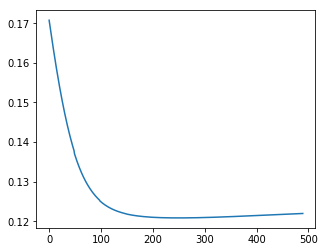

In [82]:
p = 2 # Num classes

topology = [p, 2, 1] #Why not?

learn = 1e-3

neural_n = create_nn(topology, sigm)

loss = []


for i in range(500):

    Y_hat = Train(neural_n, X, Y, l2_cost, learn)
    
    
    if i % 50:
        
        loss.append(l2_cost[0](Y, Y_hat))
        

        
        
        
plt.plot(range(len(loss)), loss)
